Data are provided by LTA DataMall
For more information on the API, refer to LTA DataMall:
https://www.mytransport.sg/content/dam/datamall/datasets/LTA_DataMall_API_User_Guide.pdf

#Step 1: Dataset is requested through API and write the raw data to json to save under stops.json and routes.json.  By saving the data to json, it will help save the hassle of re-running of Step 1. 

Note:  Loading time is 3 minutes for each run.

In [1]:
import requests
import json

#this is Account Number belongs to me and please do not abuse it !!!!!
headers = { 'AccountKey' : 'ItWWO3oVRjKsZvfoUDC9uw==','accept' : 'application/json'} 

def fetch_all(url):
    results = []
    while True:
        new_results = requests.get(
            url,
            headers=headers,
            params={'$skip': len(results)}
        ).json()['value']
        if new_results == []:
            break
        else:
            results += new_results
    return results

if __name__ == "__main__":
    stops = fetch_all("http://datamall2.mytransport.sg/ltaodataservice/BusStops")
    with open("stops.json", "w") as f:
        f.write(json.dumps(stops))
    
    services = fetch_all("http://datamall2.mytransport.sg/ltaodataservice/BusServices")

    routes = fetch_all("http://datamall2.mytransport.sg/ltaodataservice/BusRoutes")
    
    with open("routes.json", "w") as f:
        f.write(json.dumps(routes))

In [2]:
#Find out the total number of Bus Stops, Routes and services in Singaoore.
print ("Total SG Bus Stops: "+ str(len(stops)))
print ("Total SG Bus Routes: "+ str(len(routes)))

Total SG Bus Stops: 5038
Total SG Bus Routes: 26048


#Step 2: Data Pre-processing 1 (Initialising of Data for Network Graph)

Bus stops are pair up to establish of SG Bus Network in the following 3 conditions.
a) Attribute (ServiceNo) shall be the same with current and next stop
b) Attribute (Direction) shall be the same with current and next stop
c) Attribute (StopSequence) shall be in conservative number, if Next Stop = 4, then Current Stop =5.

There are a lot of attributes in the JSON that are not required. The following are the required attributes which have written to CSV file('BusNetwork.csv'). 

Attribute or Definition
BusStopCode : Point A (Current Bus Stop) or Point B (Next Bus Stop)
Roadname:  Name of the Road
Description: Bus Stop Description Name
Bussequence: Bus Stop Sequence (For connect the bus stop to bus stop based on the bus number)
ServiceNoA: Bus Number
Direction: 1 or 2 
Distance = DistanceB-DistanceA (km)

Note:  By saving the refined data to CSV, it will help save the hassle of re-running of Step 2. 
Loading time is 10minutes for each run.

In [3]:
import csv

graph = {}
with open('BusNetwork.csv','w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Point A','Road Name A', 'Description A','Point B', 
                     'Road Name B', 'Description B','Bus No.', 'Dist (km)','LatitudeA',
                     'LongitudeA','LatitudeB', 'LongitudeB'])
    
    for i in range(0,len(routes)):
        #Departure (From Point A)
        ServiceNoA = routes[i]['ServiceNo']
        StopSequenceA = routes[i]['StopSequence']
        BusStopCodeA = routes[i]['BusStopCode']
        DistanceA = routes[i]['Distance']
        
        
        #Arrival (To Point B)
        # Easy to get error due to IndexError: list index out of range due to i+1
        try:
            ServiceNoB = routes[i+1]['ServiceNo']
            StopSequenceB = routes[i+1]['StopSequence']
            BusStopCodeB = routes[i+1]['BusStopCode']
            DistanceB = routes[i+1]['Distance']
            
        except:
            continue
        
        #Bus Stop will pair up together based on the bus route under the following 2 conditions are met
        if ServiceNoA == ServiceNoB: 
            if StopSequenceB - StopSequenceA == 1:
                    # Easy to get error because of missing attributes in Busstop code such 
                    # as "E4402" in the file - routes.json  
                    try:
                        Dist = float(DistanceB-DistanceA)
                        RoadnameA = [stops[j]['RoadName'] for j in range(0,len(stops)) 
                                     if stops[j]['BusStopCode']== str(BusStopCodeA)][0]
                        RoadnameB = [stops[j]['RoadName'] for j in range(0,len(stops)) 
                                     if stops[j]['BusStopCode']== str(BusStopCodeB)][0]
                        DescriptionA = [stops[j]['Description'] for j in range(0,len(stops)) 
                                        if stops[j]['BusStopCode']== str(BusStopCodeA)][0]
                        DescriptionB = [stops[j]['Description'] for j in range(0,len(stops)) 
                                        if stops[j]['BusStopCode']== str(BusStopCodeA)][0]
                        LatitudeA = [stops[j]['Latitude'] for j in range(0,len(stops)) 
                                        if stops[j]['BusStopCode']== str(BusStopCodeA)][0]
                        LongitudeA = [stops[j]['Longitude'] for j in range(0,len(stops)) 
                                        if stops[j]['BusStopCode']== str(BusStopCodeA)][0]
                        LatitudeB = [stops[j]['Latitude'] for j in range(0,len(stops)) 
                                        if stops[j]['BusStopCode']== str(BusStopCodeA)][0]
                        LongitudeB = [stops[j]['Longitude'] for j in range(0,len(stops)) 
                                        if stops[j]['BusStopCode']== str(BusStopCodeA)][0]
                    except: 
                        continue
                    WriteToCSV = [BusStopCodeA, RoadnameA, DescriptionA, BusStopCodeB, RoadnameB, 
                                  DescriptionB, ServiceNoA, Dist,LatitudeA,LongitudeA,LatitudeB, LongitudeB]
                    writer.writerow(WriteToCSV)


Step 3: Data Preprocessing 2 (further define for data of network graph)
To filter for 3 Mature (Hougang, Ang Mo Kio, Tampines) and 3 Non Mature (Sengkang, Bt Batok, Woodlands) Estate. 

Buses that are served within the estate will be considered for the study. Let say if the Point A is within the estate but Point B is outside the estate or vice versa, it will not be considered for the study. This is to ensure the Buses are serving for the local population of the estate. 

When HDB is developing any new estate, it will always like to call Estate name and followed by Lorong, Road, Avenue or Street. Thus estate name shall be the substring of the roadname in order to be considered in the study. For example: 'Ang Mo Kio' is the substring of Road Name 'Ang Mo kio Ave 3', in this case, it will be considered for the study. Moreover, most of the private housings are found in unique road names such as Thomson road which belongs to Ang Mo Kio. Therefore, the unique road name such as Thomson road is justified of not considering in the study. 

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import csv

input_file = open('BusNetwork.csv', 'r')
data = [row for row in csv.reader(input_file)]

Estate= ("Hougang", "Sengkang", 'Ang Mo Kio', 'Bt Batok', 'Tampines', 'Woodlands')
for y in range(0,len(Estate)):
    with open(Estate[y] +'.csv','w', newline='') as f:
        writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Point A','Road Name A', 'Description A',
                         'Point B', 'Road Name B', 'Description B','Bus No.', 'Dist (km)','LatA','LongA','LatB', 'LongB','color'])
        for x in range(1,len(data)):
            if Estate[y] in data[x][1] and Estate[y] in data[x][4]:
                writer.writerow(data[x]+['orange'])
    print(str(Estate[y]) +".csv: Generated")

Hougang.csv: Generated
Sengkang.csv: Generated
Ang Mo Kio.csv: Generated
Bt Batok.csv: Generated
Tampines.csv: Generated
Woodlands.csv: Generated


Step 4 Network Graph Establishment 
Establish of Estate Network Graph (Directed) for 3 Mature (Hougang, Ang Mo Kio, Tampines) and 3 Non Mature (Sengkang, Bt Batok, Woodlands) Estate.

Network Measurement- Degree, Node, Edge, Density, Clustering (Top 3) and Degree (Top 3)  are also performed. Plot of the Degree Probability for each estate

C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


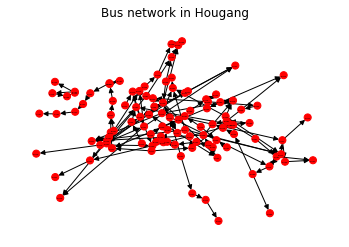

['Hougang', '110', '142', '0.011843202668890742', '64009', 'Hougang Ctrl Int', 8, '64361', 'Blk 535', 5, '64031', 'Blk 436', 5, '64399', 'Blk 512', 0.16666666666666666, '64391', 'Blk 831', 0.16666666666666666, '64389', 'Blk 522', 0.05]
Result-Hougang has recorded to CSV


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


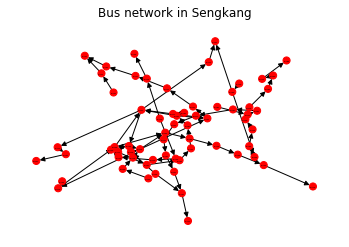

['Sengkang', '67', '72', '0.016282225237449117', '67441', 'Sengkang Community Hub', 6, '67449', 'Blk 323B', 6, '67409', 'Sengkang Stn', 5, '67009', 'Sengkang Int', 0.16666666666666666, '67109', 'Blk 235', 0.16666666666666666, '67409', 'Sengkang Stn', 0.1]
Result-Sengkang has recorded to CSV


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


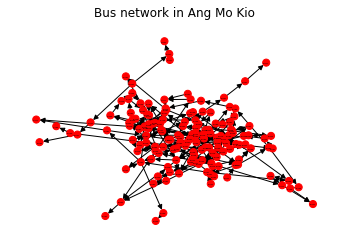

['Ang Mo Kio', '157', '215', '0.008778376612771517', '55509', 'Yio Chu Kang Int', 10, '54009', 'Ang Mo Kio Int', 9, '54241', 'Blk 700B', 6, '55239', 'Sbst Ang Mo Kio Depot', 0.16666666666666666, '55311', 'Opp Yio Chu Kang Stadium', 0.16666666666666666, '54261', 'Aft Ang Mo Kio Stn Exit A', 0.16666666666666666]
Result-Ang Mo Kio has recorded to CSV


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


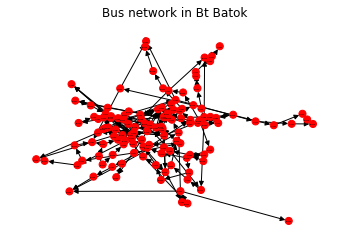

['Bt Batok', '129', '182', '0.011022286821705427', '43009', 'Bt Batok Int', 8, '43411', 'Opp Blk 628', 7, '43419', 'Aft Bt Batok Stn/Blk 628', 7, '43709', 'Blk 644', 0.16666666666666666, '43701', 'Blk 225', 0.16666666666666666, '43461', 'Aft Bt Batok West Ave 5', 0.16666666666666666]
Result-Bt Batok has recorded to CSV


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


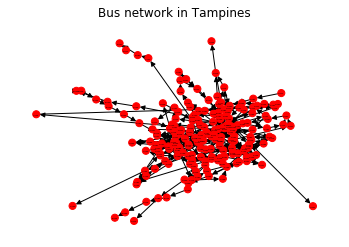

['Tampines', '200', '276', '0.006934673366834171', '75009', 'Tampines Int', 10, '76199', 'BLK 503', 7, '76191', 'BLK 401', 7, '76031', 'TAMPINES EAST STN EXIT B', 0.16666666666666666, '75121', 'Opp Darul Ghufran Mque', 0.08333333333333333, '75129', 'Darul Ghufran Mque', 0.08333333333333333]
Result-Tampines has recorded to CSV


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


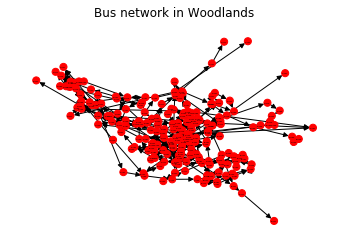

['Woodlands', '210', '266', '0.006060606060606061', '46009', "W'Lands Temp Int", 12, '46779', 'Admiralty Stn', 6, '46008', "W'Lands Temp Int", 5, '46281', 'Blk 825', 0.08333333333333333, '46279', 'Blk 803', 0.08333333333333333, '46009', "W'Lands Temp Int", 0.007575757575757576]
Result-Woodlands has recorded to CSV


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import csv

Estate= ("Hougang", "Sengkang", 'Ang Mo Kio', 'Bt Batok', 'Tampines', 'Woodlands')
with open("Result_General" +'.csv','w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    Label1 = ['Estate','Total Nodes', 'Total Edges','Density','1st Node', 'Description','Highest Deg', 
              '2nd Node', 'Description','2nd Highest Deg','3rd Node', 'Description','3rdHighest Deg',
             '1st Node', 'Description','Highest CC','2nd Node', 'Description','2nd Highest CC',
             '3rd Node', 'Description','3rd Highest CC']
    
    writer.writerow(Label1) 
    for y in Estate:
        input_file = open(y + '.csv', 'r')
        data = [row for row in csv.reader(input_file)]
        
        gn = nx.DiGraph()
        
        def D(RN):
            Description = [stops[j]['Description'] for j in range(0,len(stops)) 
                       if stops[j]['BusStopCode']== str(RN)][0]
            
            return(Description)
        
        for x in range(1,len(data)):
            gn.add_node(str(data[x][0]), color= str(data[x][12]))
            gn.add_node(str(data[x][3]), color= str(data[x][12])) 
            gn.add_edge(str(data[x][0]), str(data[x][3]), weight=str(data[x][7])) 

        node_color = []
        for node in gn.nodes(data=True):
            node_color.append('red')
        
        plt.title('Bus network in ' + str(y))
        nx.draw(gn, with_labels=True, node_size=50, node_color=node_color,linewidths=1, font_size=2)
        plt.savefig('Network for '+ str(y)+ '.pdf')
        plt.show() 
        
        #Write Result to CSV
        
        #Network Measurements
        gn.name = y
        Name = str(gn.name)
        Node = str(gn.number_of_nodes())
        Edge = str(gn.number_of_edges())
        Density = str(nx.density(gn))
        Deg = sorted(list((nx.degree(gn))), key=lambda x: x[1])[-3:] #Top 3 Player
        Degree= [Deg[2][0],D(Deg[2][0]),Deg[2][1],Deg[1][0],D(Deg[1][0]),Deg[1][1],Deg[0][0],D(Deg[0][0]),Deg[0][1]]
        Clu = sorted(list((nx.clustering(gn)).items()), key=lambda x: x[1])[-3:] #Top 3 Player
        Clustering= [Clu[2][0],D(Clu[2][0]),Clu[2][1],Clu[1][0],D(Clu[1][0]),Clu[1][1],Clu[0][0],D(Clu[0][0]),Clu[0][1]]
        
        Result = [Name, Node, Edge, Density] + Degree + Clustering
        print(Result)
        
        writer.writerow(Result)
        
        # Plot Degree Distribution
        in_degrees= gn.in_degree()
        in_values= range(0,30)
        in_hist = [list(dict(in_degrees).values()).count(x) for x in in_values]
        out_degrees= gn.out_degree()
        out_values= range(0,30)
        out_hist = [list(dict(out_degrees).values()).count(x) for x in in_values]
        plt.figure() # you need to first do 'import pylabas plt'
        plt.grid(True)
        plt.plot(in_values, in_hist, 'ro-') # in-degree
        plt.plot(out_values, out_hist, 'bv-') # out-degree
        plt.legend(['In-degree', 'Out-degree'])
        plt.xlabel('Degree')
        plt.ylabel('Number of nodes')
        plt.xlim([1, 30])
        plt.title('Degree Distribution in '+ str(gn.name))
        plt.xlim([1, 30])
        plt.savefig('Degree Distribution in '+ str(gn.name)+ '.pdf')
        plt.close()    
        
        plt.close()
        print ("Result-" + Name + " has recorded to CSV")
    
        

Step 5: Community Detection 
The alorgrithm will be based on using Strong Connected Components to detect for the community. Based on that, will perform network measure and also key player detection using the betweenness centrality.   

C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


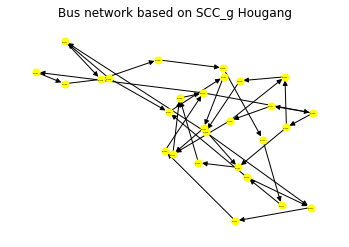

['Hougang', '28', '36', '0.047619047619047616', '15', '6.62962962962963', '0.6132478632478633']


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


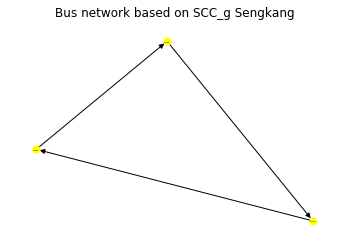

['Sengkang', '3', '3', '0.5', '2', '1.5', '0.5']


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


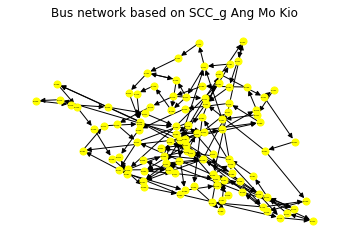

['Ang Mo Kio', '104', '148', '0.013816280806572068', '22', '9.749159820761763', '0.3289755060600293']


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


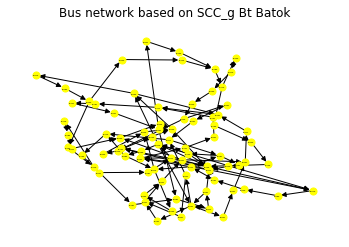

['Bt Batok', '81', '113', '0.01743827160493827', '24', '9.448302469135802', '0.3597573839662447']


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


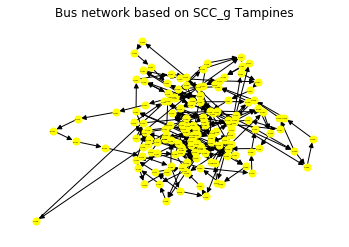

['Tampines', '147', '223', '0.010390457552884168', '27', '10.006616345168204', '0.2963218390804599']


C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\ss7s0685\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


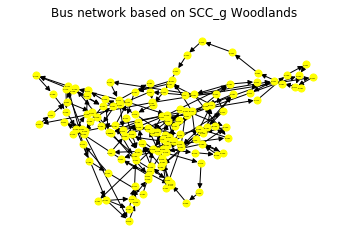

['Woodlands', '139', '182', '0.009488061724533417', '32', '12.003753518923991', '0.5577506259035927']


In [6]:
#Detect for key player based on Density, Centrality - Degree & Betweenness (Distance), Diameter
import csv

Estate= ("Hougang", "Sengkang", 'Ang Mo Kio', 'Bt Batok', 'Tampines', 'Woodlands')
with open("Result_Community Detection" +'.csv','w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    Label2 = ['Estate','Nodes','edges','Density_SCC', 'Diameter_SCC','Path_length_SCC','Betweenness_SCC']
    writer.writerow(Label2) 
    for y in Estate:
        input_file = open(y + '.csv', 'r')
        data = [row for row in csv.reader(input_file)]
        
        gn = nx.DiGraph()
        
        def D(RN):
            Description = [stops[j]['Description'] for j in range(0,len(stops)) 
                       if stops[j]['BusStopCode']== str(RN)][0]
            
            return(Description)
        
        for x in range(1,len(data)):
            gn.add_node(str(data[x][0]), color= str(data[x][12]))
            gn.add_node(str(data[x][3]), color= str(data[x][12])) 
            gn.add_edge(str(data[x][0]), str(data[x][3]), weight=str(data[x][7])) 
        try:
            Dia_SCC = str(nx.diameter(SCC_g))
        except:
            Dia_SCC = "Failed"
   
        #Community Detection based on Strongly/Weakly connected components
        SCC = list(max(nx.strongly_connected_components(gn), key=len))
        SCC_g = gn.subgraph(SCC)
        SCC_nodes = str(SCC_g.number_of_nodes())
        SCC_edges = str(SCC_g.number_of_edges())
      
        plt.title('Bus network based on SCC_g ' + str(y))
        nx.draw(SCC_g, with_labels=True, node_size=50, node_color='yellow',linewidths=1, font_size=2)
        plt.savefig('Network for SCC_g '+ str(y)+ '.pdf')
        plt.show()     
        

        Density_SCC = str(nx.density(SCC_g))
        Average_shortest_path_length_SCC= str(nx.average_shortest_path_length(SCC_g))
        Diameter_SCC = str(nx.diameter(SCC_g))
        Between_SCC = str(max(nx.betweenness_centrality(SCC_g).items(), key=lambda x : x[1])[1])
        
        Result3 = [y,SCC_nodes, SCC_edges, Density_SCC, Diameter_SCC, Average_shortest_path_length_SCC , Between_SCC] 
        print(Result3)
        writer.writerow(Result3)
        
